# EDA — Abalone Dataset

In [1]:
# --- Setup ---
import os, pathlib, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (7, 4)
pd.set_option("display.max_columns", 50)

# Dataset path: set via env or edit directly
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
data_path = os.path.join(notebook_dir, "..", "data", "abalone.csv")
df = pd.read_csv(data_path)
print(df.shape)
df.head()

(4177, 9)


,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7



## 1. Basic info & target


In [2]:

df.info()
display(df.describe(include="all"))

# Commonly the target is 'Rings' (age ≈ Rings + 1.5)
if "Rings" in df.columns:
    df["Age"] = df["Rings"] + 1.5
    display(df[["Rings", "Age"]].describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4177 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
count,4177,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
unique,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,NaN,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,NaN,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,NaN,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,NaN,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,NaN,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000


,Rings,Age
count,4177.000000,4177.000000
mean,9.933684,11.433684
std,3.224169,3.224169
min,1.000000,2.500000
25%,8.000000,9.500000
50%,9.000000,10.500000
75%,11.000000,12.500000
max,29.000000,30.500000


## 2. Missing values & duplicates

In [3]:

na_counts = df.isna().sum().sort_values(ascending=False)
display(na_counts[na_counts>0])
print("Duplicates:", df.duplicated().sum())


Series([], dtype: int64)

Duplicates: 0


## 3. Distributions

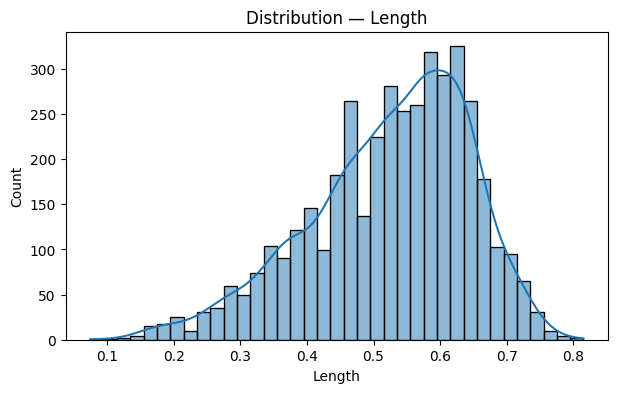

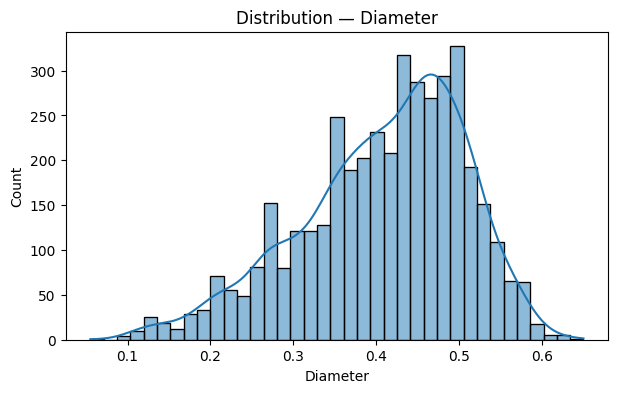

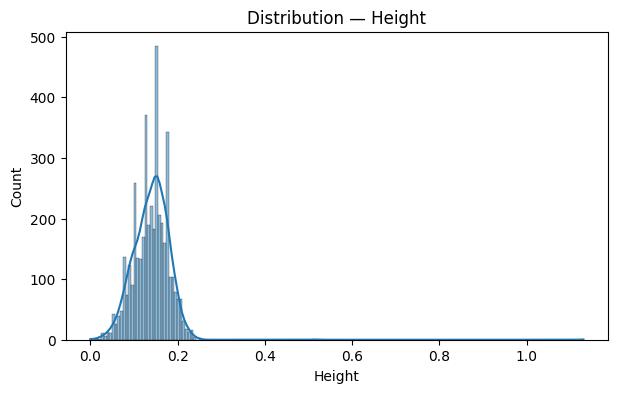

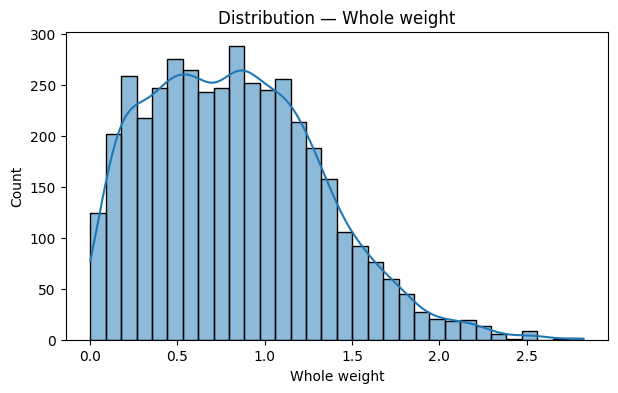

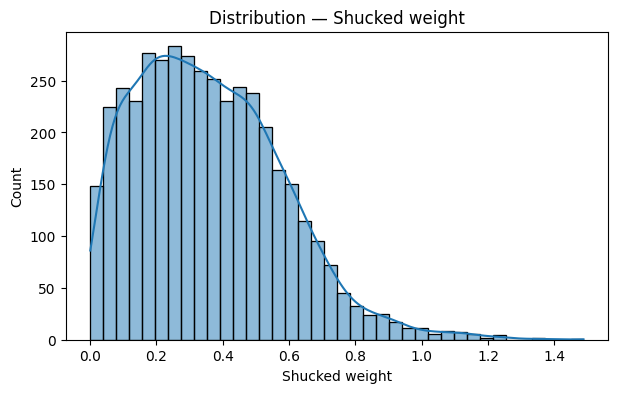

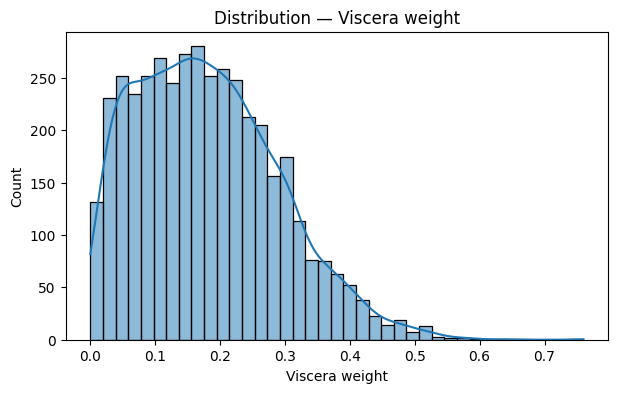

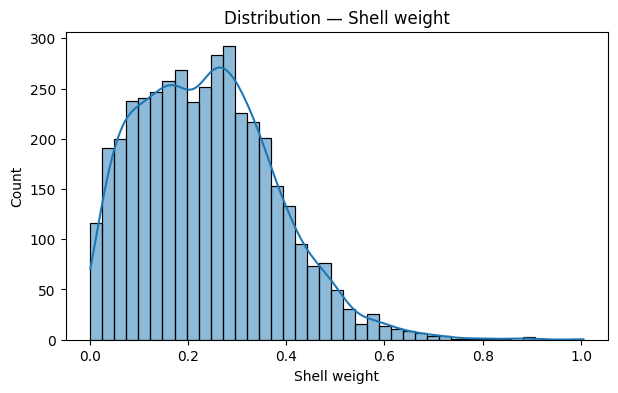

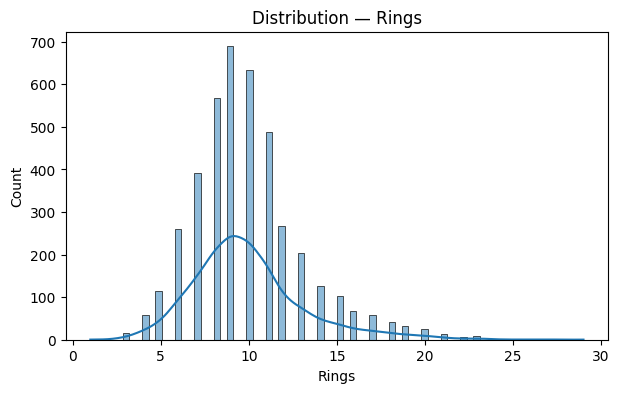

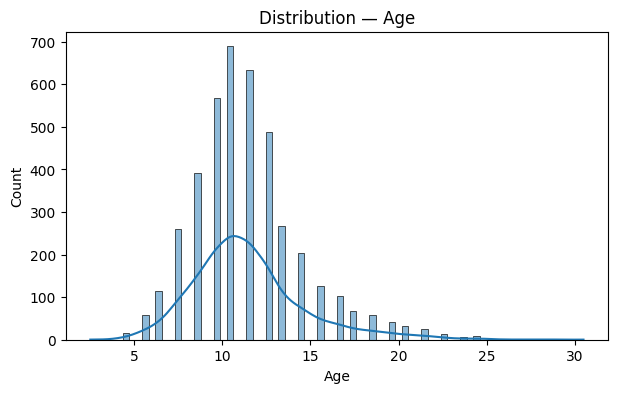

In [4]:

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
for c in num_cols[:12]:  # limit for quick pass
    ax = sns.histplot(df[c], kde=True)
    ax.set_title(f"Distribution — {c}")
    plt.show()


## 4. Target vs. Features

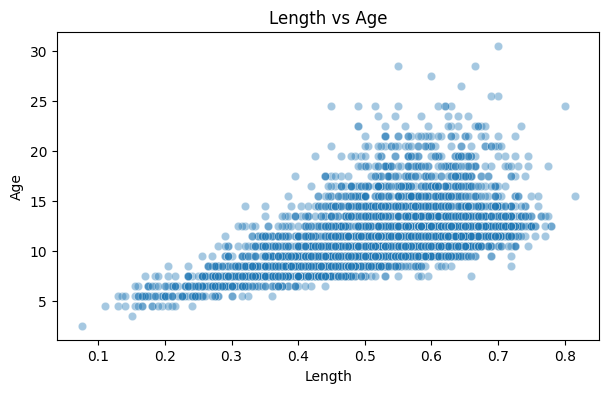

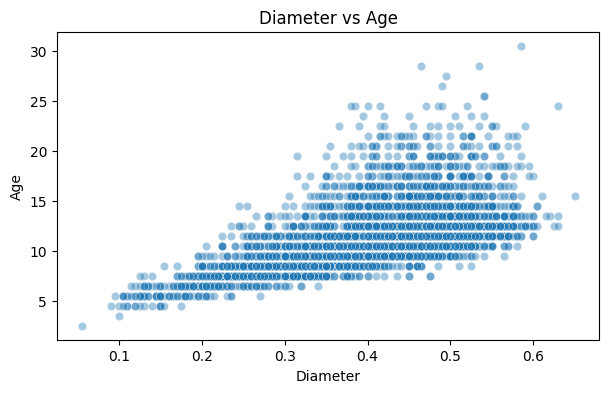

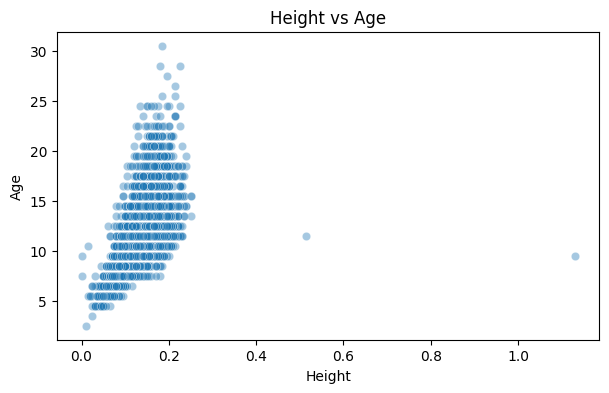

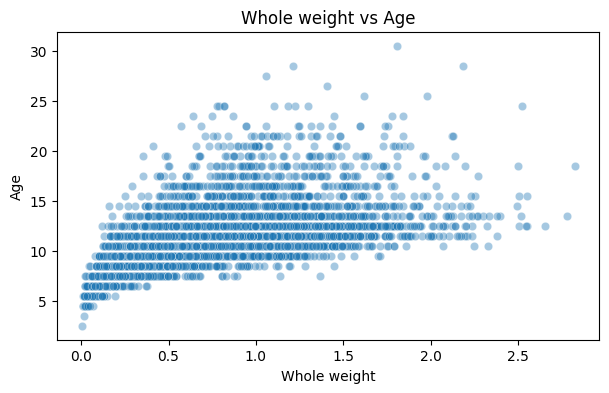

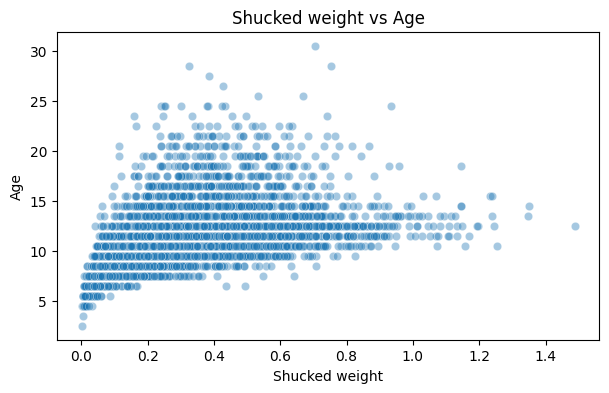

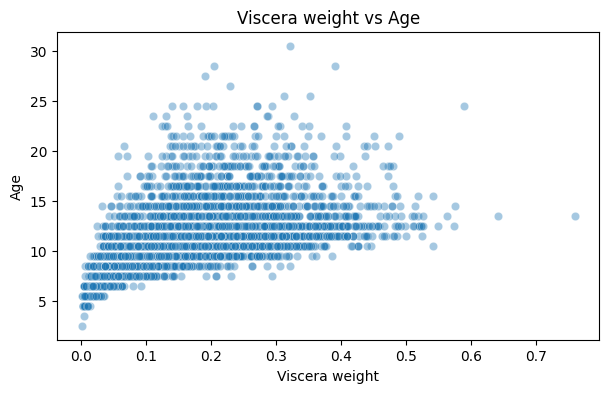

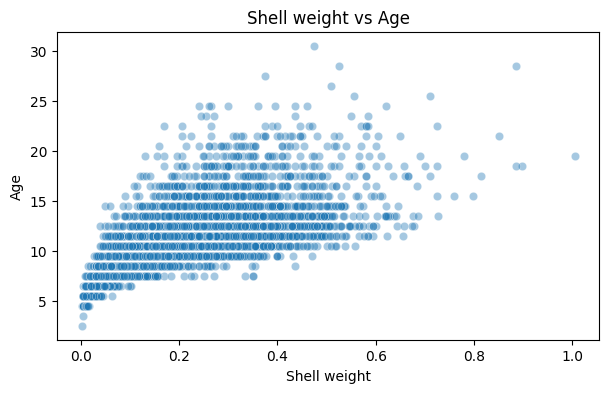

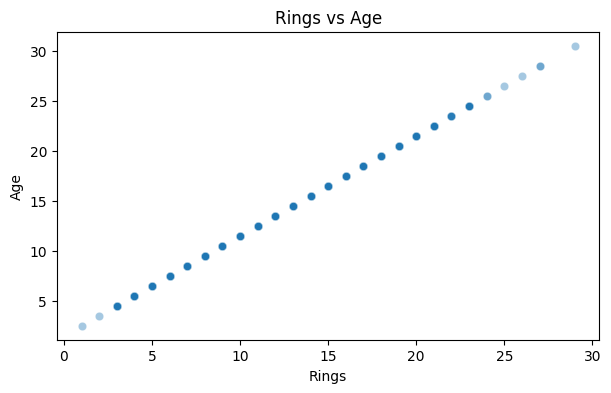

In [5]:

target = "Age" if "Age" in df.columns else ("Rings" if "Rings" in df.columns else None)
if target is not None:
    for c in [x for x in num_cols if x != target][:12]:
        ax = sns.scatterplot(x=df[c], y=df[target], alpha=0.4)
        ax.set_title(f"{c} vs {target}")
        plt.show()
else:
    print("Target column not found. Make sure 'Rings' exists in the dataset.")


## 5. Correlations

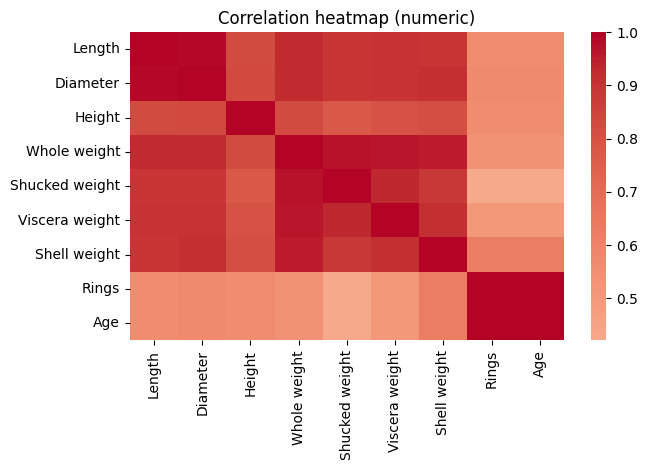

Rings             1.000000
Age               1.000000
Shell weight      0.627574
Diameter          0.574660
Height            0.557467
Length            0.556720
Whole weight      0.540390
Viscera weight    0.503819
Shucked weight    0.420884
Name: Age, dtype: float64


In [6]:

corr = df.select_dtypes(include=[np.number]).corr(numeric_only=True)
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation heatmap (numeric)")
plt.show()

if "Age" in corr.columns:
    print(corr["Age"].sort_values(ascending=False).head(15))
elif "Rings" in corr.columns:
    print(corr["Rings"].sort_values(ascending=False).head(15))



## 6. Categorical analysis
Commonly, `Sex` ∈ {M, F, I}. Check target differences across categories.


Sex
M    1528
I    1342
F    1307
Name: count, dtype: int64

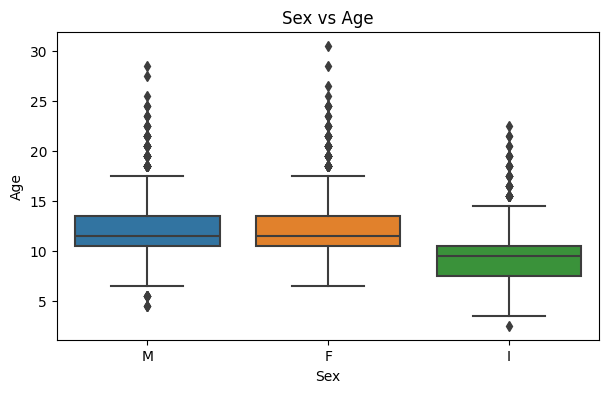

In [7]:

cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()
target = "Age" if "Age" in df.columns else ("Rings" if "Rings" in df.columns else None)

for c in cat_cols:
    display(df[c].value_counts())
    if target is not None:
        ax = sns.boxplot(x=df[c], y=df[target])
        ax.set_title(f"{c} vs {target}")
        plt.show()
